In [17]:
import noise
import gym
import matplotlib.pyplot as plt
import numpy as np


from pyglet import gl
import cProfile


class Game:
    def __init__(self, name, use_vae, num_controls, num_obs_dims, experience_file, vae_file = None,
                unet_length = 256):
        self.name = name
        self.use_vae = use_vae
        self.num_controls = num_controls
        self.num_obs_dims = num_obs_dims
        self.experience_file = experience_file
        self.vae_file = vae_file
        self.fulldata_dim = num_controls + num_obs_dims + 1
        self.unet_length = unet_length
#game = Game("CarRacing-v0", True, 3, 32, "more_runs.pickle", "vae_cnn_mnist.h5", 256)
#game = Game("CartPole-v1", False, 2, 4, None, None, 256)
#game = Game("Acrobot-v1", False, 3, 6, None, None, 256)
#game = Game("BipedalWalker-v2", False, 4, 24, "some_walks.pickle", None, 256)
game = Game("Pong-ram-v0", False, 6, 128, None, None, 256)
env = gym.make(game.name)

import pickle
class Run:
    def __init__(self):
        self.obs_l = []
        self.reward_l = []
        self.action_l = []


/home/hastings/.local/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(1057, 128)
Discrete(6)
CPU times: user 949 ms, sys: 292 ms, total: 1.24 s
Wall time: 1.26 s


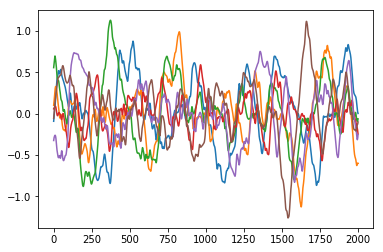

In [19]:
%%time
class Run:
    def __init__(self):
        self.obs_l = []
        self.reward_l = []
        self.action_l = []
    
from noise import pnoise1
def makeActionArray():
    start = np.random.random(game.num_controls) * 10000
    out = []
    for _ in range(2000):
        action = [ 1.7 * pnoise1(_ / 200 + start_i, 5) for start_i in start]
        out.append(action)
    return np.array(out)
al = makeActionArray()
plt.plot(al)


def randomRun(sparse = False, encoded=True):
    _ = env.reset()
    done = False
    run = Run()

    #run.action_l = makeActionArray()
    action = env.action_space.sample()
    i = 0
    while not done:
        #action = run.action_l[i]
        action = env.action_space.sample()
        i += 1
        obs, reward, done, _ = env.step(action)
        #action_l.append(action)
        if(i % 10 == 0 or not sparse):
            run.obs_l.append(obs)
        run.reward_l.append(reward)
        if (len(run.reward_l) % 1 == 0):
            env.render()
    if encoded:
        run.obs_l = vae.encoder.predict(np.array(run.obs_l) / 255.)
    return run

run = randomRun(encoded=False)
print(np.array(run.obs_l).shape)
print(env.action_space)

In [20]:
import keras

import numpy as np
import keras

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding1D
from keras.layers import MaxPooling1D, Lambda
from keras.layers.convolutional import UpSampling2D, Conv1D, Cropping1D
from keras.models import Sequential, Model
from keras.layers import MaxPooling1D, concatenate, Add
import keras.backend as K

def make_q_networks():
    input_ = Input((game.num_obs_dims,))
    #x = BatchNormalization()(input_)
    x = Dense(56, activation="relu")(input_)
    x = Dense(56, activation="relu")(x)
    
    models = []
    
    for action in actions:
        output = Dense(1, activation="linear")(x)

        model = Model(input_, output)
        model.compile(loss="mse", optimizer=keras.optimizers.adam())
        models.append(model)
    return models

actions = list(range(game.num_controls))
qs = make_q_networks()

In [21]:
explore_coefficient = .5
decay = .99
env.spec.max_episode_steps = 3000

In [22]:
import random
episodes = [0]
def qRun(sparse = False, encoded=False, update=True):
    _ = env.reset()
    done = False
    run = Run()
    
    #run.action_l = makeActionArray()
    action = env.action_space.sample()
    i = 0
    while not done:
        i += 1
        obs, reward, done, _ = env.step(action)
        obs = obs / 255.
        
        #training_pair = [run.obs_l[-1], action, reward, obs]
        
        reward = reward / 15
        run.action_l.append(action)
        if(i % 1 == 0 or not sparse):
            run.obs_l.append(obs)
        run.reward_l.append(reward)
        if (len(run.reward_l) % 1 == 0):
            env.render()
        import time
        #time.sleep(.06)
        if random.random() < explore_coefficient:
            action = env.action_space.sample()
        else:
            scores = [qn.predict(np.expand_dims(obs, 0))[0, 0] for qn in qs]
            #print(scores, end="         \r")
            idx = np.argmax(scores)
            action = actions[idx]
            #print(action)
            
    if encoded:
        run.obs_l = vae.encoder.predict(np.array(run.obs_l) / 255.)
    if(update):
        train(run)
    episodes[0] += 1
    print(15 * np.sum(run.reward_l))
    return run
        
def train(run):
    #updated_qs = []
    #for j in range(len(run.obs_l)- 1):
    #    updated_qs.append(run.reward_l[j] + decay * max([qn.predict(np.expand_dims(run.obs_l[j], 0))[0, 0] for qn in qs]))
    #updated_qs.append(run.reward_l[-1])
    #updated_qs = np.expand_dims(updated_qs, -1)
    run.obs_l = np.array(run.obs_l)
    run.reward_l = np.array(run.reward_l)
    run.action_l = np.array(run.action_l)
    updated_qs_2 = run.reward_l + decay * np.max([qn.predict(run.obs_l)[:, 0]for qn in qs], 0)
    
    updated_qs_2[-1] = run.reward_l[-1]
    updated_qs_2 = np.expand_dims(updated_qs_2, 1)
    
    
    #print(updated_qs.shape, updated_qs_2.shape)
    
    #print(updated_qs - updated_qs_2)
    
    
    
    #print(updated_qs)
    run.obs_l = np.array(run.obs_l)
    for action in actions:
        idx = np.array(run.action_l[1:]) == action
        #print(idx)
        #print(run.obs_l, updated_qs)
        #print(run.obs_l[:-1][idx], updated_qs[1:][idx])

        if(np.any(idx)):
            qs[action].fit(run.obs_l[:-1][idx], updated_qs_2[1:][idx], verbose=False)
    return run
run = qRun()

-21.000000000000004


In [23]:
env = gym.make(game.name)

In [ ]:
explore_coefficient = 0.3
runs = []
for _ in range(10000):
    explore_coefficient = .3 * random.random()
    print(explore_coefficient)
    runs.append(qRun())
    runs = runs[-400:]
    for r in range(30):
        train(random.choice(runs))

0.09145692089168424
-21.000000000000004
0.283595820779225
-21.000000000000004
0.05538694145867435
-21.000000000000004
0.29008498051807435
-21.000000000000004
0.22025324470002614
-21.000000000000004
0.1718883024121206
-20.000000000000004
0.15832818036061466
-21.000000000000004
0.029456397824541403
-21.000000000000004
0.07718017726592542
-21.000000000000004
0.17852437318934936
-20.000000000000004
0.07331330410925711
-21.000000000000004
0.02244857415622301
-21.000000000000004
0.2309896763010211
-21.000000000000004
0.16243478954284477
-21.000000000000004
0.23602980019383035
-21.000000000000004
0.13256125496137103
-21.000000000000004
0.04476923871764977
-21.000000000000004
0.10954910803373487
-21.000000000000004
0.06561784664359534
-21.000000000000004
0.06988558135590002
-21.000000000000004
0.231931873211406
-21.000000000000004
0.15759655071820708
-21.000000000000004
0.16649681117272658
-21.000000000000004
0.16847544992685973
-21.000000000000004
0.14558701982258412
-21.000000000000004
0.283

0.12402834959401744
-21.000000000000004
0.01491655342582373
-21.000000000000004
0.14805492504974038
-21.000000000000004
0.042529266068606054
-21.000000000000004
0.13673334413874205
-21.000000000000004
0.14292091424577077
-20.000000000000004
0.009021830300013156
-21.000000000000004
0.15509481698628733
-21.000000000000004
0.1155860774172075
-19.000000000000004
0.23307176613816175
-21.000000000000004
0.1461901727893613
-21.000000000000004
0.04025275754581099
-21.000000000000004
0.09595688606264552
-21.000000000000004
0.09342288512772386
-20.000000000000004
0.2758649340348212
-21.000000000000004
0.27202839775552323
-20.000000000000004
0.016868657039556322
-21.000000000000004
0.014168256343865725
-21.000000000000004
0.009944285684482034
-21.000000000000004
0.18307144588265603
-21.000000000000004
0.19119400970087505
-21.000000000000004
0.14156950582109412
-21.000000000000004
0.2617322511385977
-21.000000000000004
0.15689669934124903
-21.000000000000004
0.18001992588456042
-20.000000000000004

-21.000000000000004
0.11756296691476807
-20.000000000000004
0.039770698458939865
-21.000000000000004
0.2900077403539969
-21.000000000000004
0.2876589635611717
-21.000000000000004
0.10446070214252344
-21.000000000000004
0.21105592241129015
-21.0
0.007110355079333119
-21.000000000000004
0.0361128529224121
-21.000000000000004
0.08216882825990432
-21.000000000000004
0.15301858052324385
-21.000000000000004
0.28020100617545884
-21.000000000000004
0.12879717672396088
-21.000000000000004
0.07926305165096668
-21.000000000000004
0.2590376977818231
-21.000000000000004
0.1291355583604427
-21.000000000000004
0.2750513937437377
-21.000000000000004
0.1528182916196301
-21.000000000000004
0.2606527914076431
-21.000000000000004
0.26807647284571184
-20.000000000000004
0.18049155461260294
-19.0
0.0901717539954208
-20.000000000000004
0.18054346854408945
-21.000000000000004
0.1799474973133479
-20.000000000000004
0.22447495539683412
-21.000000000000004
0.08536461048891597
-21.000000000000004
0.00590824505138

0.12471545384983426
-21.000000000000004
0.09199868243809714
-21.000000000000004
0.07356530787685879
-21.000000000000004
0.0945990553032699
-21.000000000000004
0.10179911020767458
-21.000000000000004
0.011552911487004413
-21.000000000000004
0.2238691730290521
-20.000000000000004
0.29773414204240484
-21.000000000000004
0.12136999737231369
-21.000000000000004
0.058782700467552025
-21.000000000000004
0.10339036197412467
-21.000000000000004
0.2720882764695064
-21.000000000000004
0.04064540475566747
-21.000000000000004
0.012815736276444067
-21.000000000000004
0.09124761853480859
-20.000000000000004
0.25193756389322464
-21.000000000000004
0.2656174090963833
-21.000000000000004
0.2720220278784493
-21.000000000000004
0.04126806503939904
-21.000000000000004
0.24824975462219348
-21.000000000000004
0.2866922263803216
-21.000000000000004
0.1431822104911177
-21.000000000000004
0.14075607641397317
-21.000000000000004
0.2237418132956827
-21.000000000000004
0.02288684895777113
-21.000000000000004
0.199

0.15432437995844894
-21.0
0.009254354155111543
-21.000000000000004
0.25092017972665503
-21.000000000000004
0.17743546274688157
-20.000000000000004
0.0027649771272326485
-21.000000000000004
0.22351224810470102
-21.000000000000004
0.13997268919247674
-20.000000000000004
0.16854712222956403
-21.000000000000004
0.22179549307087715
-20.000000000000004
0.27076288960776407
-21.000000000000004
0.187252877826896
-21.000000000000004
0.2487991120094925
-21.000000000000004
0.09953464825569641
-21.000000000000004
0.17911162816692494
-20.000000000000004
0.038681012854316785
-21.000000000000004
0.09666474724343706
-21.000000000000004
0.0955163512232108
-20.000000000000004
0.2843800234698864
-20.000000000000004
0.0024750049573041277
-21.000000000000004
0.18345169351497595
-20.000000000000004
0.2611555626868406
-21.000000000000004
0.18452225629982302
-20.000000000000004
0.05457741963338753
-21.000000000000004
0.23554005941033965
-21.000000000000004
0.17612039336909907
-21.000000000000004
0.228181702257

0.227287049665317
-21.000000000000004
0.0419062768632163
-21.000000000000004
0.10895846856555447
-21.000000000000004
0.29147812527371536
-21.000000000000004
0.0405577411741934
-21.000000000000004
0.2728571923494807
-21.000000000000004
0.11293338253653018
-21.000000000000004
0.291340940559633
-21.000000000000004
0.21182420475276417
-20.000000000000004
0.06512556380628821
-21.000000000000004
0.27826564807456033
-21.000000000000004
0.09670990961418914
-21.000000000000004
0.13702468919689373
-21.000000000000004
0.26684829971519597
-21.000000000000004
0.1712335879270461
-21.000000000000004
0.15588886554752127
-20.000000000000004
0.0009225549593200432
-21.000000000000004
0.1150048069850353
-21.000000000000004
0.11834772903260309
-21.000000000000004
0.11512875207779849
-21.000000000000004
0.20341084187116132
-20.000000000000004
0.17223634519923373
-21.000000000000004
0.10744549726999071
-21.000000000000004
0.1993974226981908
-21.000000000000004
0.0893420933908189
-21.000000000000004
0.0220342

0.21197160963269188
-21.000000000000004
0.12733056536157472
-21.000000000000004
0.12992835978425138
-21.000000000000004
0.16632885081594898
-21.000000000000004
0.11407219182061902
-21.000000000000004
0.1293329974863501
-20.000000000000004
0.05719613370475407
-21.000000000000004
0.01062407544614975
-21.000000000000004
0.19853151039665046
-21.000000000000004
0.003443288908827369
-21.000000000000004
0.24910392816805083
-21.000000000000004
0.28308817927206864
-21.000000000000004
0.2832519716630624
-20.000000000000004
0.2092449616969912
-21.000000000000004
0.2621276023884348
-20.000000000000004
0.15375360440945002
-21.000000000000004
0.29909595817285983
-21.000000000000004
0.23634087924592595
-21.000000000000004
0.11952050340253814
-21.000000000000004
0.2909510813847764
-21.000000000000004
0.05329198037398686
-21.000000000000004
0.06094695414272541
-21.000000000000004
0.05659627942573042
-21.000000000000004
0.23716031336371107
-20.000000000000004
0.2403652542899799
-21.000000000000004
0.142

0.10199043036325275
-20.000000000000004
0.18506308316179917
-21.000000000000004
0.15781220257256134
-17.0
0.28310298145971513
-21.000000000000004
0.09567531265268948
-21.000000000000004
0.07016769559706555
-21.000000000000004
0.10339458957904675
-21.000000000000004
0.22095358243940694
-21.000000000000004
0.006600529722357217
-21.000000000000004
0.2956196415241389
-21.000000000000004
0.08017531835999177
-21.000000000000004
0.08576154221350808
-21.000000000000004
0.07064734599394758
-21.000000000000004
0.18823914607263229
-20.000000000000004
0.09129618984912383
-21.000000000000004
0.07926657378853352
-21.000000000000004
0.18317653248441015
-20.000000000000004
0.22383406079421547
-21.000000000000004
0.09467125905777433
-21.000000000000004
0.24757411710110025
-21.000000000000004
0.2215797132405947
-21.000000000000004
0.2433101520121802
-21.000000000000004
0.18081827134059472
-21.000000000000004
0.2097560045888789
-21.000000000000004
0.010735759355582063
-21.000000000000004
0.06351663610947

0.13186082032529553
-21.000000000000004
0.05341325582408428
-21.000000000000004
0.07251329189310492
-20.000000000000004
0.1667371210815236
-21.000000000000004
0.2773816651241248
-21.000000000000004
0.19937625964131547
-21.000000000000004
0.08193237130519061
-21.000000000000004
0.21304064046736385
-21.000000000000004
0.09924642943582426
-20.000000000000004
0.04526318388612666
-21.000000000000004
0.23562066505108462
-21.000000000000004
0.058771679412969076
-20.000000000000004
0.2704791726519774
-21.000000000000004
0.2131910791531503
-21.000000000000004
0.23732784292812276
-21.000000000000004
0.09258510858209197
-20.000000000000004
0.17504133267964941
-20.000000000000004
0.06635352960508885
-21.000000000000004
0.1262160465836157
-20.000000000000004
0.22849884945014895
-20.000000000000004
0.008962203269498025
-21.000000000000004
0.14811777884151592
-20.000000000000004
0.004734009762767699
-21.000000000000004
0.03656788226665292
-21.000000000000004
0.2864520198837427
-21.000000000000004
0.1

0.1757275486415363
-21.000000000000004
0.14761019080847473
-21.000000000000004
0.24198129427859422
-21.000000000000004
0.16182783337485895
-21.000000000000004
0.22432490972949046
-20.000000000000004
0.2623276973965173
-21.000000000000004
0.011619288906601855
-21.000000000000004
0.06232946766143866
-21.000000000000004
0.12689435371295552
-20.000000000000004
0.03833059445694518
-21.000000000000004
0.25984454938189416
-20.000000000000004
0.061600846415161836
-20.000000000000004
0.17415470650925016
-21.0
0.09987151042583996
-21.000000000000004
0.24781184484484503
-21.000000000000004
0.10531377330584897
-21.000000000000004
0.26434767186160907
-21.000000000000004
0.22634381706035656
-20.000000000000004
0.1392652407566989
-20.000000000000004
0.26649152107910595
-21.000000000000004
0.2212960999396241
-21.000000000000004
0.09428864538546626
-21.000000000000004
0.22119810615112656
-20.000000000000004
0.15568135640172345
-21.000000000000004
0.02595487745737123
-21.000000000000004
0.24731967090642

0.10548675200774861
-21.000000000000004
0.10053908580720738
-21.000000000000004
0.17871094366277301
-20.000000000000004
0.07130415221197789
-21.000000000000004
0.13473099273241632
-21.000000000000004
0.26439029671428926
-21.000000000000004
0.0061442997397752165
-21.000000000000004
0.0663253247557684
-21.000000000000004
0.21720688912670297
-21.000000000000004
0.17847705871410988
-21.000000000000004
0.1072825679094775
-21.000000000000004
0.21449035685744736
-21.000000000000004
0.16426814145293683
-21.000000000000004
0.11743865592436986
-21.000000000000004
0.18177169345223362
-21.000000000000004
0.09223554969532506
-21.000000000000004
0.09836567643230566
-21.000000000000004
0.14555843597012827
-21.000000000000004
0.18974599272510967
-21.000000000000004
0.020604555262826906
-21.000000000000004
0.033461516903568835
-21.000000000000004
0.20229897584865933
-21.000000000000004
0.13740967949655447
-20.000000000000004
0.05409148475409947
-21.000000000000004
0.24019719109350054
-20.00000000000000

0.11348594691894431
-21.000000000000004
0.280757570814673
-21.000000000000004
0.19804843178294113
-21.000000000000004
0.1298779643178524
-21.000000000000004
0.12477435780470253
-21.000000000000004
0.1872001229885208
-21.000000000000004
0.07306735060599723
-21.000000000000004
0.16222917539822637
-21.000000000000004
0.060950060270329606
-21.000000000000004
0.05800171910938568
-21.000000000000004
0.23724379817905028
-18.000000000000004
0.18183261586564858
-21.000000000000004
0.07340835557176435
-21.000000000000004
0.17375397429266934
-21.000000000000004
0.15674147572792826
-21.000000000000004
0.11017785012501245
-21.000000000000004
0.2899239292109997
-21.000000000000004
0.15010343318838357
-21.000000000000004
0.13473182628915667
-21.000000000000004
0.08447297029706313
-21.000000000000004
0.10813353878731509
-21.000000000000004
0.023638603556605475
-21.000000000000004
0.28696383127486996
-21.000000000000004
0.09778106390179554
-21.000000000000004
0.11896324637785236
-21.000000000000004
0.0

-21.000000000000004
0.18405185704574706
-20.000000000000004
0.06844616437296426
-21.000000000000004
0.15421109315225298
-21.000000000000004
0.17489052342285194
-21.000000000000004
0.21776548671545673
-21.000000000000004
0.14132206729216404
-21.000000000000004
0.2826694365394527
-21.000000000000004
0.20834646245107566
-21.000000000000004
0.25934899040366555
-21.000000000000004
0.2660319314946264
-21.000000000000004
0.11050051607500908
-21.000000000000004
0.031564911320922436
-21.000000000000004
0.290213979040506
-21.000000000000004
0.2721970376310343
-20.000000000000004
0.14058562056323756
-20.000000000000004
0.07856364514740942
-21.000000000000004
0.0653718241263032
-21.000000000000004
0.1361816493625121
-21.000000000000004
0.20877279164447196
-21.000000000000004
0.26527153662157027
-21.000000000000004
0.0032579256588784354
-21.000000000000004
0.14421533749631166
-21.000000000000004
0.045426692072664976
-21.000000000000004
0.09394374384410926
-21.000000000000004
0.1397692080761036
-20.

-21.000000000000004
0.29116349542977765
-21.000000000000004
0.1779882176869275
-21.000000000000004
0.2873579296849173
-21.000000000000004
0.05295202595786497
-21.000000000000004
0.09606389261516918
-21.000000000000004
0.19910898382833248
-21.000000000000004
0.15792880803695852
-21.000000000000004
0.12852067925682772
-21.000000000000004
0.008066538014435387
-21.000000000000004
0.25598259421337816
-21.000000000000004
0.1966322808642562
-21.0
0.23816902988048422
-21.000000000000004
0.06661746110338464
-21.000000000000004
0.13444582362492216
-21.000000000000004
0.24093453081535532
-21.000000000000004
0.08601776793441086
-21.0
0.027973094736717673
-21.000000000000004
0.041948424540774396
-21.000000000000004
0.24099309056153462
-21.000000000000004
0.011873305972894531
-21.000000000000004
0.16749118439155153
-20.000000000000004
0.2798081683482386
-19.0
0.0808868580290029
-21.000000000000004
0.0795407678998135
-21.000000000000004
0.10387480411422072
-21.000000000000004
0.20274609972410795
-21.

0.15051449558286495
-21.0
0.2911120053048563
-21.000000000000004
0.17154276612946734
-21.000000000000004
0.29447728318880473
-20.000000000000004
0.23880716301297814
-21.000000000000004
0.07274022516428799
-21.000000000000004
0.17168181559418766
-20.000000000000004
0.29133365495985736
-20.000000000000004
0.18758089326647923
-21.000000000000004
0.01629160197398407
-21.000000000000004
0.09606046873141316
-20.000000000000004
0.04193783398918024
-21.000000000000004
0.03947557493425968
-21.000000000000004
0.12790635981065748
-21.000000000000004
0.1636371639864213
-19.0
0.11722315443980141
-21.000000000000004
0.08689352755397405
-21.000000000000004
0.2763722771641052
-21.000000000000004
0.20180438042085072
-21.000000000000004
0.21432149913499565
-21.000000000000004
0.0025221309445788154
-21.000000000000004
0.16146840160134993
-21.000000000000004
0.11890878039601468
-21.000000000000004
0.08616824927048973
-21.000000000000004
0.0956307156299439
-21.000000000000004
0.09505459435380585
-21.000000

0.26003458024709164
-21.000000000000004
0.2605869896456036
-21.000000000000004
0.17681585945060665
-21.000000000000004
0.053233147382991265
-21.000000000000004
0.029749177976505847
-21.000000000000004
0.16553499085395604
-21.000000000000004
0.22276738828195045
-21.000000000000004
0.1748087920407705
-20.000000000000004
0.20898932977771562
-20.000000000000004
0.01227784647669986
-21.000000000000004
0.0372510974069513
-21.000000000000004
0.26474133808479394
-21.000000000000004
0.0346711071466129
-21.000000000000004
0.14839433625696005
-21.000000000000004
0.15321083261211862
-21.000000000000004
0.256511817327136
-21.000000000000004
0.24589322897465843
-21.000000000000004
0.1878656810827862
-21.000000000000004
0.05115030473662073
-21.000000000000004
0.06541803918606837
-21.000000000000004
0.25742034127848507
-21.000000000000004
0.03814261931432573
-20.000000000000004
0.23344265657099675
-21.000000000000004
0.29347918248348953
-20.000000000000004
0.006349809667753436
-21.000000000000004
0.24

0.1639020628825238
-20.000000000000004
0.28539870377961307
-21.000000000000004
0.11349660202733963
-21.000000000000004
0.1934689498255501
-21.000000000000004
0.04618545685303098
-21.000000000000004
0.0668251245920978
-21.000000000000004
0.0926505040684054
-21.000000000000004
0.04233356565373547
-21.000000000000004
0.08598889037925217
-21.000000000000004
0.2053625049464629
-21.000000000000004
0.060919509772544386
-20.000000000000004
0.23717763018163257
-20.000000000000004
0.17707505201747756
-21.000000000000004
0.023061017264543657
-21.000000000000004
0.21406975824453264
-21.000000000000004
0.2384542297719267
-21.000000000000004
0.19220158532461615
-20.000000000000004
0.09085700239069547
-21.000000000000004
0.13762325411262258
-21.000000000000004
0.17541708053166535
-21.000000000000004
0.014421067847415037
-21.000000000000004
0.18233438842626745
-21.000000000000004
0.26324872135938154
-20.000000000000004
0.2036618433300507
-21.000000000000004
0.22150674260508194
-19.000000000000004
0.15

0.15182967382564644
-20.000000000000004
0.2426952668579427
-21.000000000000004
0.1825921159259409
-21.000000000000004
0.13726853292959643
-21.000000000000004
0.1873347868005827
-21.000000000000004
0.28779776581204314
-21.000000000000004
0.15812013410135828
-19.0
0.054780686472650754
-21.000000000000004
0.18230437333018348
-21.000000000000004
0.1840022862038428
-21.000000000000004
0.12568047539911745
-21.000000000000004
0.18062886032277878
-21.000000000000004
0.1781891776745158
-21.000000000000004
0.21843925141688758
-21.000000000000004
0.06383389577151674
-21.000000000000004
0.21718808789812763
-18.000000000000004
0.009799246101025639
-21.000000000000004
0.16580042985551707
-21.000000000000004
0.2450079671037615
-21.000000000000004
0.03301715513921588
-21.000000000000004
0.08776002504395793
-21.0
0.10051268807766561
-21.000000000000004
0.29424373309734475
-20.000000000000004
0.12831734446967516
-20.000000000000004
0.02474049147669898
-21.000000000000004
0.2929116899945781
-21.000000000

-21.000000000000004
0.10427073845141459
-21.000000000000004
0.01838237618668249
-21.000000000000004
0.2337398447818744
-20.000000000000004
0.03782599862891982
-21.000000000000004
0.06181154024687856
-21.000000000000004
0.2159762670112998
-21.000000000000004
0.294369456556955
-21.000000000000004
0.04618449327334784
-21.000000000000004
0.24749345143060097
-21.000000000000004
0.15957477056082348
-20.000000000000004
0.053347792750737484
-21.000000000000004
0.21599395444784017
-21.000000000000004
0.16879633521569323
-21.000000000000004
0.04820337292721152
-21.000000000000004
0.14372185749369773
-21.000000000000004
0.23714629831583325
-20.000000000000004
0.011719650033479112
-21.000000000000004
0.1637363449561697
-21.000000000000004
0.18295056439738455
-21.000000000000004
0.24830453266924565
-21.000000000000004
0.05891552163447156
-21.000000000000004
0.1243516692157961
-21.000000000000004
0.046570636300353706
-21.000000000000004
0.1149097792741471
-21.000000000000004
0.16929020909155765
-21.

-19.000000000000004
0.04507116085404672
-21.000000000000004
0.08474593978625754
-21.000000000000004
0.006792210732150993
-21.000000000000004
0.21091038091869982
-20.000000000000004
0.098253117508195
-21.000000000000004
0.25965777788627353
-21.000000000000004
0.2650833799438798
-21.000000000000004
0.08481989408597942
-21.000000000000004
0.2724435506641804
-21.000000000000004
0.2209480751689603
-21.000000000000004
0.0840720426863115
-21.000000000000004
0.017976700846044656
-21.0
0.0751444328352849
-21.000000000000004
0.07569698154140099
-21.000000000000004
0.006839496640911135
-21.000000000000004
0.028068937945747195
-21.000000000000004
0.27973378567956764
-21.000000000000004
0.015460382275421047
-21.000000000000004
0.009202258331940837
-21.000000000000004
0.02339646612333829
-21.000000000000004
0.05670844951632503
-21.000000000000004
0.21714591765152846
-21.000000000000004
0.16242503944323675
-21.000000000000004
0.12898566921728347
-20.000000000000004
0.06226600511773391
-21.00000000000

-21.000000000000004
0.10855229730035391
-21.000000000000004
0.26952496446718105
-21.000000000000004
0.2914978667739713
-21.000000000000004
0.1290066466519312
-21.000000000000004
0.15933581861019977
-19.0
0.0005759602611048353
-20.000000000000004
0.037199893144490556
-21.000000000000004
0.13704634638898666
-21.000000000000004
0.004227251499364748
-21.000000000000004
0.09822749385236562
-21.000000000000004
0.05665698671720107
-21.000000000000004
0.2174593460334809
-21.000000000000004
0.019779031624252597
-21.000000000000004
0.1808403557813146
-20.000000000000004
0.22157613317723562
-21.000000000000004
0.08731477475564821
-21.000000000000004
0.10895874019449277
-21.000000000000004
0.10016878804818072
-21.000000000000004
0.1840869672759267
-21.000000000000004
0.14882728093079808
-21.000000000000004
0.10952527795582435
-21.000000000000004
0.08706704793269662
-20.000000000000004
0.12172325464837269
-21.0
0.17542318956219174
-20.000000000000004
0.2817736346578066
-21.000000000000004
0.0876378

-21.000000000000004
0.14852064925030578
-21.000000000000004
0.22018357912119926
-21.000000000000004
0.0031483695323041294
-21.000000000000004
0.20077820857429676
-21.000000000000004
0.18169611620896026
-20.000000000000004
0.28051125381273606
-20.000000000000004
0.11732268445574992
-21.000000000000004
0.16526853791453758
-20.000000000000004
0.11472616774050748
-21.000000000000004
0.22947725650862189
-21.000000000000004
0.25437687492270833
-19.0
0.12295350337482498
-21.000000000000004
0.23794643278716368
-21.000000000000004
0.012193863863351395
-21.000000000000004
0.1320044673215451
-21.000000000000004
0.28886577702714256
-21.000000000000004
0.0820311935046859
-21.000000000000004
0.015342510684190125
-21.000000000000004
0.11816270321975791
-20.000000000000004
0.2189808787732534
-21.000000000000004
0.2293756536409276
-21.000000000000004
0.18109736969168236
-20.000000000000004
0.1179211234978979
-21.000000000000004
0.14353070931916442
-21.000000000000004
0.07807884028093448
-20.00000000000

-21.000000000000004
0.004065043476136975
-21.000000000000004
0.006596275527372031
-21.000000000000004
0.02590658308944078
-21.000000000000004
0.07615811361151333
-21.000000000000004
0.052852154401235814
-21.000000000000004
0.09186733086232632
-21.000000000000004
0.13599457486523156
-21.000000000000004
0.15485427196272875
-20.000000000000004
0.2594777329602632
-21.000000000000004
0.05144029698367941
-21.000000000000004
0.2899861062974885
-21.000000000000004
0.13457275477380642
-20.000000000000004
0.17432371154310028
-21.000000000000004
0.28024949390388604
-21.000000000000004
0.2839311258971351
-21.000000000000004
0.08697695443797837
-21.000000000000004
0.13822888970903005
-21.000000000000004
0.0007186438321920674
-21.000000000000004
0.10500044413113292
-21.000000000000004
0.2342153545208059
-21.000000000000004
0.014906612969107502
-20.000000000000004
0.293485431096552
-21.000000000000004
0.005540018588349449
-20.000000000000004
0.020279476132275796
-21.000000000000004
0.2710448119550866

0.048267755824984826
-21.000000000000004
0.1052135058174379
-21.000000000000004
0.018978155600937095
-21.000000000000004
0.2989759389973229
-21.000000000000004
0.028793706150677542
-21.000000000000004
0.05113617881968776
-21.000000000000004
0.09357034435808503
-21.000000000000004
0.2144444529778636
-21.0
0.0680455155429301
-21.000000000000004
0.275108931837998
-21.000000000000004
0.28900601885827987
-21.000000000000004
0.06641897171531967
-21.000000000000004
0.15161910167835638
-21.000000000000004
0.28897737129587825
-21.0
0.24347882809706942
-21.000000000000004
0.24876448003336066
-20.000000000000004
0.11507412554772756
-21.000000000000004
0.06347050420858455
-21.000000000000004
0.19551166818735444
-21.000000000000004
0.2429516460727153
-20.000000000000004
0.24696235523678423
-21.000000000000004
0.0989325867150246
-21.000000000000004
0.17357427440765114
-21.000000000000004
0.09399257619254199
-21.000000000000004
0.24648575001681938
-21.000000000000004
0.03693190341044595
-21.000000000

-21.000000000000004
0.274870200958346
-21.000000000000004
0.06801608006823812
-20.000000000000004
0.08666655400221258
-21.000000000000004
0.11480429610784527
-21.000000000000004
0.1647011928702096
-21.000000000000004
0.2646354799861843
-20.000000000000004
0.2341799601261904
-21.000000000000004
0.12200963835421785
-21.000000000000004
0.17125117485608501
-21.000000000000004
0.27075708150151984
-21.000000000000004
0.04669433156192869
-21.000000000000004
0.24136591973487498
-21.000000000000004
0.12224700369342546
-21.000000000000004
0.1439476298711366
-21.000000000000004
0.15685875037639177
-21.000000000000004
0.06554792287896684
-21.000000000000004
0.24438360638949916
-21.000000000000004
0.15689971546401815
-21.000000000000004
0.2800122267331313
-21.000000000000004
0.09112313442669331
-21.000000000000004
0.18881494911644375
-21.000000000000004
0.16290183644296571
-21.000000000000004
0.10795238154927216
-20.000000000000004
0.11122712468481312
-21.000000000000004
0.1396819488447961
-20.0000

0.1942892343950555
-20.000000000000004
0.08542749734788527
-21.000000000000004
0.1671022229143018
-21.000000000000004
0.2714269755456096
-20.000000000000004
0.18654576277304952
-21.000000000000004
0.19998482022825362
-21.000000000000004
0.12179259664679229
-21.000000000000004
0.14792198545770827
-21.000000000000004
0.2532708989894113
-20.000000000000004
0.2985241455272355
-20.000000000000004
0.07976822939554805
-21.000000000000004
0.2473358812456806
-21.000000000000004
0.0684711895000693
-21.000000000000004
0.24629129095027089
-20.000000000000004
0.08534867750462674
-21.000000000000004
0.10830407261330902
-21.000000000000004
0.10779819679401854
-21.000000000000004
0.21393563273615698
-21.000000000000004
0.17823612748203305
-21.000000000000004
0.2788463292449386
-21.000000000000004
0.22570845255937447
-20.000000000000004
0.26504458478178106
-21.000000000000004
0.2086101261220085
-20.000000000000004
0.05245709701865887
-21.000000000000004
0.25669994967057946
-21.000000000000004
0.2328732

-21.000000000000004
0.05336624349842761
-21.000000000000004
0.23972386837090115
-21.000000000000004
0.11774875545430052
-21.000000000000004
0.2340575864755428
-21.000000000000004
0.2523962232532717
-21.000000000000004
0.051721844711544215
-21.000000000000004
0.19154165182527935
-21.000000000000004
0.02220614894631414
-21.000000000000004
0.10975153024948046
-21.000000000000004
0.26428364004182603
-21.000000000000004
0.18529954167084062
-20.000000000000004
0.17843579392391765
-21.000000000000004
0.16764186838439213
-21.000000000000004
0.22343682844914106
-19.000000000000004
0.03629372329268586
-21.000000000000004
0.2941548385970681
-21.000000000000004
0.11906174847201068
-21.000000000000004
0.21863277306511014
-21.000000000000004
0.00667960588982317
-21.000000000000004
0.13875671652969232
-21.000000000000004
0.07322344420823751
-21.000000000000004
0.02021433814616993
-21.0
0.10734428423230581
-21.000000000000004
0.12337018006741311
-20.000000000000004
0.08366677481165812
-21.000000000000

0.27919510620981025
-20.000000000000004
0.20092009708262976
-21.000000000000004
0.21322062809747386
-19.0
0.21414496633679606
-21.000000000000004
0.02563012818201118
-21.000000000000004
0.04039582658947821
-21.000000000000004
0.26513874006978383
-21.000000000000004
0.1436498981148079
-21.000000000000004
0.07002648054315352
-21.000000000000004
0.03964074969940042
-21.000000000000004
0.2592914257888288
-21.000000000000004
0.10313264661959341
-21.000000000000004
0.12155810731614648
-20.000000000000004
0.15119038542985386
-21.000000000000004
0.15098851912335648
-21.000000000000004
0.012257279710950864
-21.000000000000004
0.22044400530403363
-21.000000000000004
0.015859102762301115
-21.000000000000004
0.059521877980108426
-21.000000000000004
0.061157208824541995
-21.000000000000004
0.2953598918975254
-20.000000000000004
0.263979366580577
-21.000000000000004
0.2711272528908739
-20.000000000000004
0.060344561070391156
-21.000000000000004
0.006796455592598605
-21.000000000000004
0.297870880459

-21.000000000000004
0.2593310618709679
-20.000000000000004
0.19388259624943857
-21.000000000000004
0.049616723591039726
-21.000000000000004
0.16891194138646592
-21.000000000000004
0.11562113366215943
-21.000000000000004
0.22529904026517933
-20.000000000000004
0.21003563339902484
-21.0
0.19693019672831247
-20.000000000000004
0.002947968188269312
-21.000000000000004
0.10095898553926769
-21.000000000000004
0.10173868038220951
-21.000000000000004
0.052535081013776894
-21.000000000000004
0.28236070529969326
-21.000000000000004
0.23320188443547732
-20.000000000000004
0.11572878562654834
-21.000000000000004
0.24437953239189023
-21.000000000000004
0.1742452610069037
-21.000000000000004
0.1936817983804361
-20.000000000000004
0.14794932826817708
-21.000000000000004
0.23331717723776016
-21.000000000000004
0.09911966869061688
-21.000000000000004
0.19734271428665187
-21.000000000000004
0.01272008303779607
-21.000000000000004
0.11756879858927563
-21.000000000000004
0.1194212066576488
-21.00000000000

-21.000000000000004
0.28073789806687555
-21.000000000000004
0.07982114139168407
-21.000000000000004
0.04817257367007988
-21.000000000000004
0.28393505392310064
-20.000000000000004
0.13017799113134812
-21.000000000000004
0.15319149334431495
-21.000000000000004
0.03164526308064964
-21.000000000000004
0.23048740848679883
-21.000000000000004
0.2707458530015114
-21.000000000000004
0.1065522153091548
-21.000000000000004
0.29806409978050197
-21.000000000000004
0.2834542256180911
-20.000000000000004
0.06952101681774141
-20.000000000000004
0.29923715666346157
-21.000000000000004
0.04368258544643033
-21.000000000000004
0.28183349548486597
-20.000000000000004
0.001987231078532137
-21.000000000000004
0.12194156945383015
-21.000000000000004
0.07199798917304302
-21.000000000000004
0.2675547801544116
-20.000000000000004
0.14742780825182436
-21.000000000000004
0.12816977254261422
-21.000000000000004
0.15175591207192943
-19.0
0.040449700626674946
-21.000000000000004
0.1289709184094463
-21.0000000000000

0.16104073177772846
-21.000000000000004
0.1392325953248582
-21.000000000000004
0.09104690793744732
-21.000000000000004
0.17034820596735295
-21.000000000000004
0.17808737102750383
-21.000000000000004
0.14347958409692893
-20.000000000000004
0.164494000866263
-21.000000000000004
0.041619097068181295
-21.000000000000004
0.284037940435492
-20.000000000000004
0.16990738065475186
-21.000000000000004
0.03549681822977443
-21.000000000000004
0.12541717230232471
-21.000000000000004
0.2931311580980958
-21.000000000000004
0.08980172798448846
-21.0
0.2790635435144926
-20.000000000000004
0.15222747468719927
-21.000000000000004
0.21292967270037938
-21.0
0.09177500295447678
-21.000000000000004
0.04951727548960911
-21.000000000000004
0.231406431432278
-20.000000000000004
0.07315684152737902
-20.000000000000004
0.06528093886240176
-21.000000000000004
0.20631966695387938
-20.000000000000004
0.03339748485178692
-21.000000000000004
0.27193481781006484
-20.000000000000004
0.08476774336403496
-19.000000000000

0.2562559668568314
-21.000000000000004
0.17619018288815988
-21.000000000000004
0.29076682083438893
-20.000000000000004
0.19081617213009258
-21.000000000000004
0.22469793420669204
-21.000000000000004
0.25550402434907565
-21.000000000000004
0.17157138009761128
-21.000000000000004
0.0033899190578915105
-21.000000000000004
0.19391946994705397
-21.000000000000004
0.0015458216124083046
-21.000000000000004
0.27416541715438725
-20.000000000000004
0.2337671252646581
-21.000000000000004
0.16703869190094064
-21.000000000000004
0.25990959246832035
-21.000000000000004
0.15429162069764824
-21.000000000000004
0.2596849066374306
-21.000000000000004
0.03922764346779867
-21.000000000000004
0.21842692782011885
-21.000000000000004
0.2701564168747115
-21.000000000000004
0.167733008071041
-21.0
0.15092396641886172
-21.000000000000004
0.195664798572941
-21.000000000000004
0.0429481850221346
-21.000000000000004
0.005860946275189727
-21.000000000000004
0.027767250717579284
-21.000000000000004
0.256458797212575

-21.000000000000004
0.26118685863087393
-21.000000000000004
0.01898153760151042
-21.000000000000004
0.10949543355813972
-21.000000000000004
0.05584698890362983
-21.000000000000004
0.0007650298367053221
-21.000000000000004
0.146696196122368
-20.000000000000004
0.1524787714526847
-21.000000000000004
0.09818143839545089
-21.000000000000004
0.2731717345923721
-21.000000000000004
0.08989104197311211
-21.000000000000004
0.2138323758853416
-21.000000000000004
0.13783637694162515
-21.000000000000004
0.11566505297318781
-20.000000000000004
0.01365969971139218
-21.000000000000004
0.26891713061991
-21.000000000000004
0.220267311511834
-21.000000000000004
0.041917973421085865
-21.000000000000004
0.2811841686243646
-21.000000000000004
0.264274112431477
-21.000000000000004
0.1280283384451801
-21.000000000000004
0.22743579572137518
-20.000000000000004
0.2948311943690195
-21.000000000000004
0.001998318954020095
-21.000000000000004
0.24406943932614134
-21.0
0.21601104043903874
-21.000000000000004
0.009

-21.000000000000004
0.19003099111661606
-21.000000000000004
0.09544173433004116
-20.000000000000004
0.0677589696319288
-21.000000000000004
0.07561286883098293
-21.000000000000004
0.014750502669549559
-21.000000000000004
0.13322537889133768
-21.000000000000004
0.1882530228434473
-21.000000000000004
0.1253973161030738
-21.000000000000004
0.12175117933355835
-21.000000000000004
0.06326988633223242
-20.000000000000004
0.09927319723191315
-21.000000000000004
0.07132758821982933
-21.000000000000004
0.2737589958619365
-21.000000000000004
0.1177989523163593
-21.000000000000004
0.20163499049066333
-21.000000000000004
0.10098655636619693
-21.000000000000004
0.15556327519829483
-21.000000000000004
0.18575430856345676
-21.000000000000004
0.07126533082864975
-21.000000000000004
0.1844936494000782
-21.000000000000004
0.2690927028334326
-21.000000000000004
0.1199186878074769
-21.000000000000004
0.26847891067450913
-21.000000000000004
0.06716553208713914
-21.000000000000004
0.15967370389088192
-21.000

In [1]:
import vae

/home/hastings/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 22, 22, 64)   32832       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 10, 10, 128)  131200      conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

NameError: name 'models' is not defined

In [28]:
explore_coefficient = 0.2
for _ in range(1000):
    qRun(update=False)

-21.000000000000004
-21.000000000000004


KeyboardInterrupt: 

In [275]:
episodes

[696]

In [276]:
len(runs)

127